In [1]:
import os
from glob import glob

ROOT_DIR = "stardew_valley_8th_lab"
cand = []
for root, dirs, files in os.walk(ROOT_DIR):
    if os.path.basename(root) == "images_48":
        cand.append(root)

IMG_DIR = sorted(cand)[0]
img_paths = sorted([p for p in glob(os.path.join(IMG_DIR, "*.png")) if not os.path.basename(p).startswith("._")])

print(len(img_paths))

1869


In [2]:
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

tfm = transforms.Compose([transforms.ToTensor()])

class Stardew48(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        x = Image.open(self.paths[i]).convert("RGB")
        return self.transform(x)

all_paths = img_paths[:]
random.shuffle(all_paths)

val_ratio = 0.15
n_val = int(len(all_paths) * val_ratio)

val_paths = all_paths[:n_val]
train_paths = all_paths[n_val:]

train_ds = Stardew48(train_paths, tfm)
val_ds = Stardew48(val_paths, tfm)

from torch.utils.data import DataLoader

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,num_workers=0, pin_memory=False)

print(len(train_ds), len(val_ds))

1589 280


In [3]:
import torch.nn as nn

class ConvAE(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, z_dim),
        )
        self.dec = nn.Sequential(
            nn.Linear(z_dim, 256 * 6 * 6),
            nn.ReLU(),
            nn.Unflatten(1, (256, 6, 6)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat, z

In [4]:
import time
from torch.utils.tensorboard import SummaryWriter

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAE(z_dim=128).to(device)

criterion = nn.L1Loss()
opt = torch.optim.Adam(model.parameters(), lr=2e-4)

log_dir = "./runs_stardew_ae"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

EPOCHS = 30

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    model.train()
    tr_sum = 0.0
    tr_n = 0
    for x in train_loader:
        x = x.to(device)
        opt.zero_grad()
        x_hat, _ = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        opt.step()
        tr_sum += loss.item() * x.size(0)
        tr_n += x.size(0)
    train_loss = tr_sum / tr_n

    model.eval()
    vl_sum = 0.0
    vl_n = 0
    with torch.no_grad():
        for x in val_loader:
            x = x.to(device)
            x_hat, _ = model(x)
            loss = criterion(x_hat, x)
            vl_sum += loss.item() * x.size(0)
            vl_n += x.size(0)
    val_loss = vl_sum / vl_n

    writer.add_scalar("loss/train", train_loss, epoch)
    writer.add_scalar("loss/val", val_loss, epoch)

    print(f"{epoch:02d} train={train_loss:.4f} val={val_loss:.4f} t={time.time()-t0:.1f}s")

writer.close()
torch.save(model.state_dict(), "./ae_last.pt")

01 train=0.3589 val=0.3202 t=1.5s
02 train=0.2871 val=0.2551 t=0.8s
03 train=0.2359 val=0.2303 t=0.8s
04 train=0.2185 val=0.2200 t=0.8s
05 train=0.2097 val=0.2102 t=0.8s
06 train=0.1978 val=0.1948 t=0.8s
07 train=0.1763 val=0.1753 t=0.8s
08 train=0.1591 val=0.1652 t=0.8s
09 train=0.1500 val=0.1550 t=0.8s
10 train=0.1430 val=0.1491 t=0.8s
11 train=0.1392 val=0.1458 t=0.8s
12 train=0.1372 val=0.1441 t=0.8s
13 train=0.1340 val=0.1418 t=0.8s
14 train=0.1317 val=0.1390 t=0.8s
15 train=0.1299 val=0.1391 t=0.8s
16 train=0.1279 val=0.1349 t=0.8s
17 train=0.1252 val=0.1330 t=0.8s
18 train=0.1234 val=0.1312 t=0.8s
19 train=0.1216 val=0.1298 t=0.8s
20 train=0.1199 val=0.1285 t=0.8s
21 train=0.1193 val=0.1273 t=0.8s
22 train=0.1177 val=0.1260 t=0.8s
23 train=0.1164 val=0.1250 t=0.8s
24 train=0.1148 val=0.1243 t=0.8s
25 train=0.1138 val=0.1234 t=0.8s
26 train=0.1128 val=0.1225 t=0.8s
27 train=0.1119 val=0.1216 t=0.8s
28 train=0.1107 val=0.1202 t=0.8s
29 train=0.1095 val=0.1192 t=0.8s
30 train=0.108

В качестве функции ошибки L1Loss, тк она обычно даёт более резкие реконструкции, чем MSE

In [5]:
%load_ext tensorboard
%tensorboard --logdir ./runs_stardew_ae

Reusing TensorBoard on port 6008 (pid 76511), started 6 days, 6:17:34 ago. (Use '!kill 76511' to kill it.)

train/val loss уменьшаются синхронно, сильного разрыва нет, val не растёт при убывающем train. Переобучения на 30 эпохах не видно. Все ок!

In [6]:
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

model = ConvAE(z_dim=128).to(device)
ckpt = "./best_ae.pt" if os.path.exists("./best_ae.pt") else "./ae_last.pt"

model.load_state_dict(torch.load(ckpt, map_location=device))
model.eval()

print(ckpt, device)

./best_ae.pt mps


In [7]:
zs = []
with torch.no_grad():
    for i, x in enumerate(train_loader):
        if i == 30:
            break
        zs.append(model.enc(x.to(device)).cpu())

z = torch.cat(zs, 0)
mu = z.mean(0)
std = z.std(0).clamp_min(1e-6)

print(float(std.mean()))

10.717191696166992


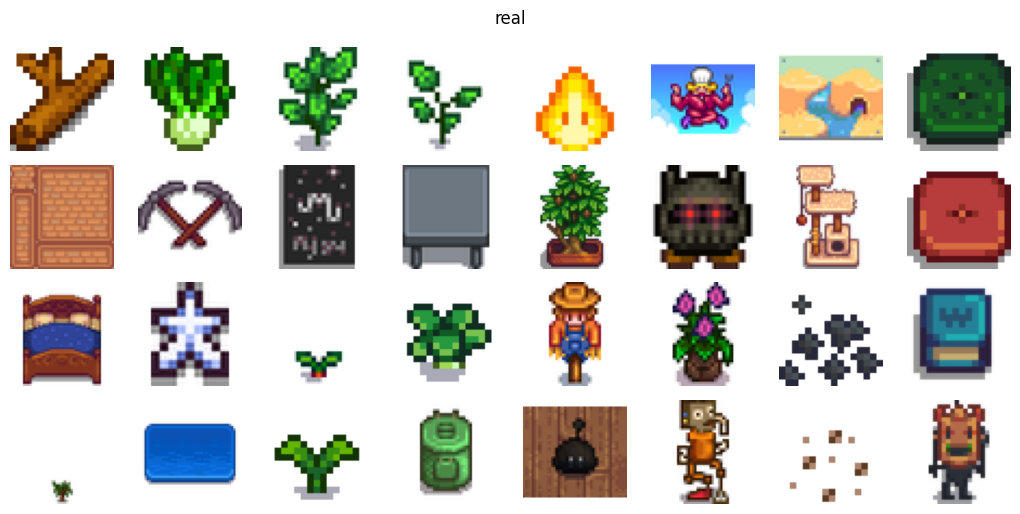

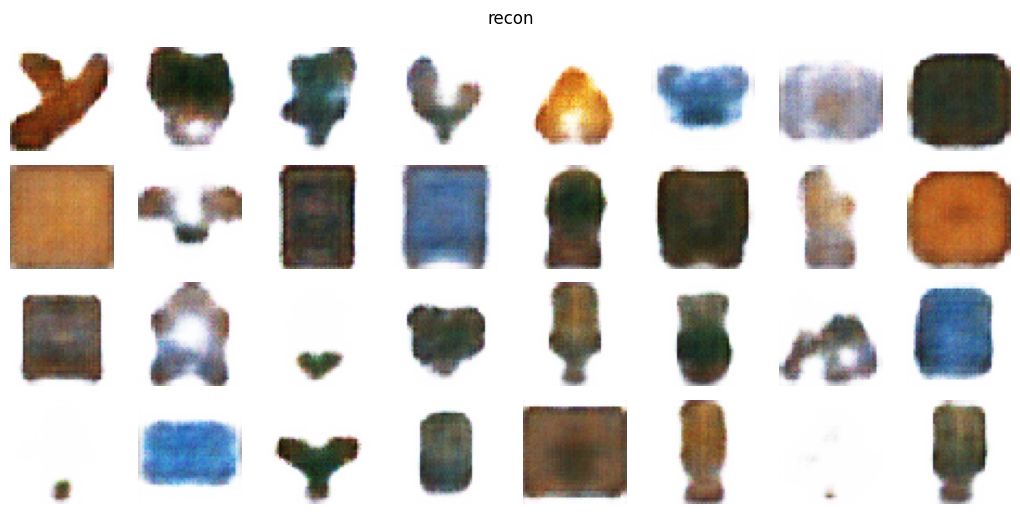

In [8]:
import math
import matplotlib.pyplot as plt

def show(imgs, ncol=8, title=""):
    imgs = imgs.detach().cpu().clamp(0, 1)
    n = imgs.size(0)
    nrow = math.ceil(n / ncol)
    plt.figure(figsize=(ncol * 1.3, nrow * 1.3))
    for i in range(n):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(imgs[i].permute(1, 2, 0))
        plt.axis("off")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

x = next(iter(val_loader))[:32].to(device)
with torch.no_grad():
    x_hat, _ = model(x)

show(x, title="real")
show(x_hat, title="recon")

форма,силуэты и основные цвета сохраняются, но детали размываются, в целом ок для AE с L1

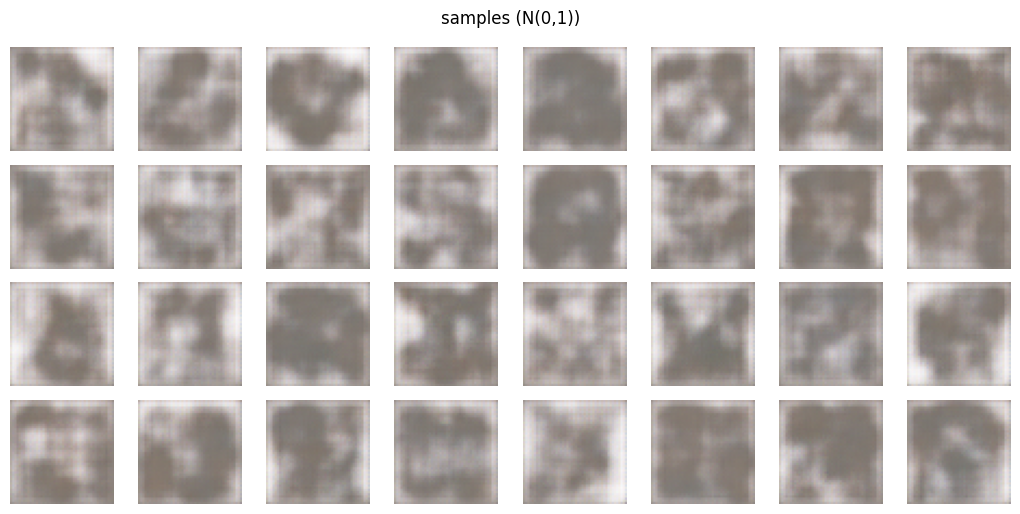

In [9]:
n = 32
z = torch.randn(n, 128).to(device)

with torch.no_grad():
    gen_noise = model.dec(z)

show(gen_noise, title="samples (N(0,1))")

Генерация из z N(0,1) выглядит хуже это ожидаемо для AE, тк онне обучается под фиксированное распределение латентного пространства.

Более похожие на данные примеры получаются, если брать латенты реальных изображений (encoder(train)) и добавлять небольшой шум.

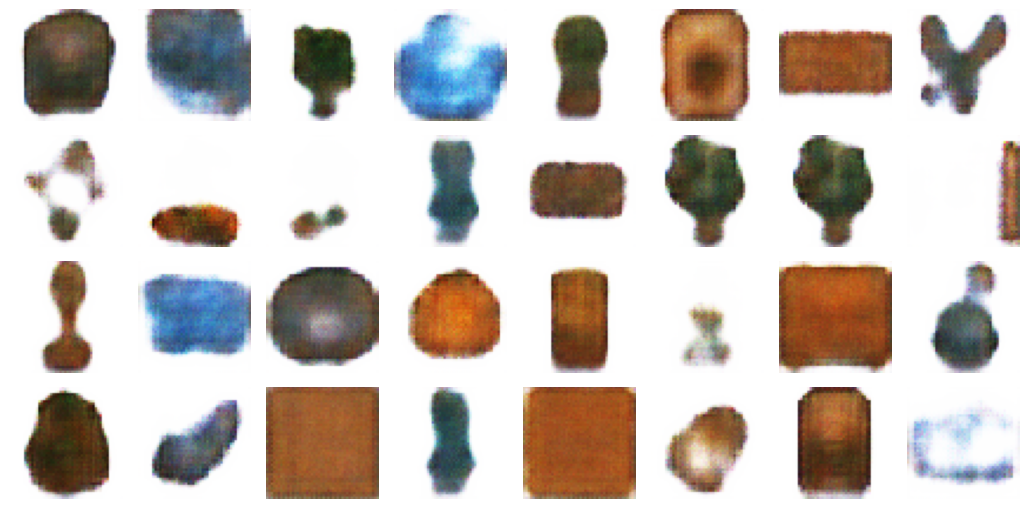

In [10]:
def collect_latents(loader, max_batches=60):
    zs = []
    with torch.no_grad():
        for i, x in enumerate(loader):
            if i >= max_batches:
                break
            x = x.to(device)
            z = model.enc(x).cpu()
            zs.append(z)
    return torch.cat(zs, dim=0)

Z = collect_latents(train_loader, max_batches=60)
z_real = Z[torch.randint(0, Z.size(0), (32,))]

z = z_real + 0.2 * torch.randn_like(z_real)

with torch.no_grad():
    gen = model.dec(z.to(device))

show(gen)

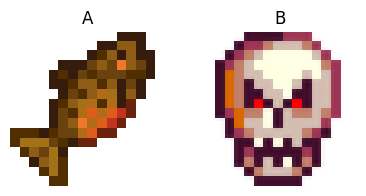

In [11]:
A_path = "stardew_valley_8th_lab/dataset/images_48/823937611249188959.png"
B_path = "stardew_valley_8th_lab/dataset/images_48/474853874380806994.png"

fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(Image.open(A_path).convert("RGB"))
ax[0].set_title("A")
ax[0].axis("off")

ax[1].imshow(Image.open(B_path).convert("RGB"))
ax[1].set_title("B")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [12]:
import imageio.v2 as imageio
import numpy as np
from IPython.display import FileLink

A_path = "stardew_valley_8th_lab/dataset/images_48/823937611249188959.png"
B_path = "stardew_valley_8th_lab/dataset/images_48/474853874380806994.png"

xA = tfm(Image.open(A_path).convert("RGB")).unsqueeze(0).to(device)
xB = tfm(Image.open(B_path).convert("RGB")).unsqueeze(0).to(device)

with torch.no_grad():
    zA = model.enc(xA)
    zB = model.enc(xB)

steps = 40
ts = torch.linspace(0, 1, steps, device=device)

frames = []
with torch.no_grad():
    for t in ts:
        z = (1 - t) * zA + t * zB
        x = model.dec(z)[0].cpu().clamp(0, 1).permute(1, 2, 0).numpy()
        frames.append((x * 255).astype(np.uint8))

gif_path = "8.gif"
imageio.mimsave(gif_path, frames, duration=0.08)

FileLink(gif_path)

/Users/safronovamaria/PycharmProjects/8-generative-Ria0666/8.gif

In [15]:
def add_noise(x, sigma=0.1):
    return (x + sigma * torch.randn_like(x)).clamp(0, 1)

In [17]:
device = "mps" if torch.backends.mps.is_available() else (
    "cuda" if torch.cuda.is_available() else "cpu"
)

model = ConvAE(z_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model

ConvAE(
  (enc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=32, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=32, out_features=9216, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 6, 6))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Sigmoid()
  )
)

In [18]:
model.train()

for x in train_loader:
    x = x.to(device)

    x_noisy = add_noise(x, sigma=0.1)
    x_hat, _ = model(x_noisy)

    loss = recon_loss(x_hat, x)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

NameError: name 'recon_loss' is not defined